In [92]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
#import nasdaqdatalink

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.stattools import acovf,acf,pacf,pacf_yw,pacf_ols
import sklearn.mixture as mix
from hmmlearn.hmm import GaussianHMM
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import sklearn.mixture as mix
from ta.momentum import RSIIndicator



import warnings
warnings.filterwarnings("ignore")

In [2]:
raw_df = yf.download("AMZN", start="2014-01-01", end="2024-08-09", period="1d")

[*********************100%%**********************]  1 of 1 completed


In [3]:
raw_df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,19.940001,19.968000,19.701000,19.898500,19.898500,42756000
2014-01-03,19.914499,20.135500,19.811001,19.822001,19.822001,44204000
2014-01-06,19.792500,19.850000,19.421000,19.681499,19.681499,63412000
2014-01-07,19.752001,19.923500,19.714500,19.901501,19.901501,38320000
2014-01-08,19.923500,20.150000,19.802000,20.096001,20.096001,46330000
...,...,...,...,...,...,...
2024-08-02,166.750000,168.770004,160.550003,167.899994,167.899994,141448400
2024-08-05,154.210007,162.960007,151.610001,161.020004,161.020004,83149400
2024-08-06,161.710007,165.080002,158.539993,161.929993,161.929993,59950800


In [4]:
df = raw_df.loc[:,["Adj Close"]]

In [5]:
df

,Adj Close
Date,
2014-01-02,19.898500
2014-01-03,19.822001
2014-01-06,19.681499
2014-01-07,19.901501
2014-01-08,20.096001
...,...
2024-08-02,167.899994
2024-08-05,161.020004
2024-08-06,161.929993


### calculation of the simple and log returns

In [6]:
# Daily percent change of the price

In [7]:
df["simple_rtn"] = df["Adj Close"].pct_change()

In [8]:
# The ratio indicates how much the price has changed from one day to the next.

In [9]:
df["log_rtn"] = np.log(df["Adj Close"] / df["Adj Close"].shift(1))

In [10]:
df

,Adj Close,simple_rtn,log_rtn
Date,,,
2014-01-02,19.898500,NaN,NaN
2014-01-03,19.822001,-0.003845,-0.003852
2014-01-06,19.681499,-0.007088,-0.007113
2014-01-07,19.901501,0.011178,0.011116
2014-01-08,20.096001,0.009773,0.009726
...,...,...,...
2024-08-02,167.899994,-0.087847,-0.091948
2024-08-05,161.020004,-0.040977,-0.041840
2024-08-06,161.929993,0.005651,0.005635


In [11]:
df.isnull().sum()

Adj Close     0
simple_rtn    1
log_rtn       1
dtype: int64

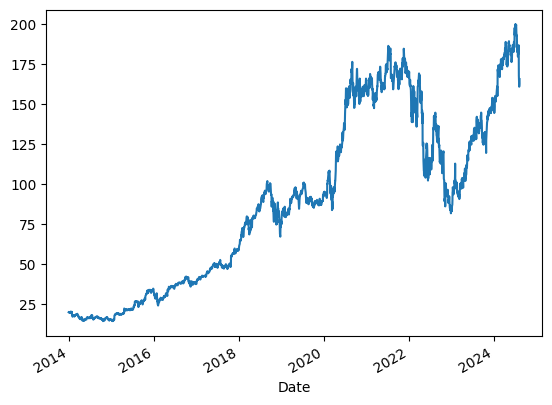

In [12]:
df["Adj Close"].plot();

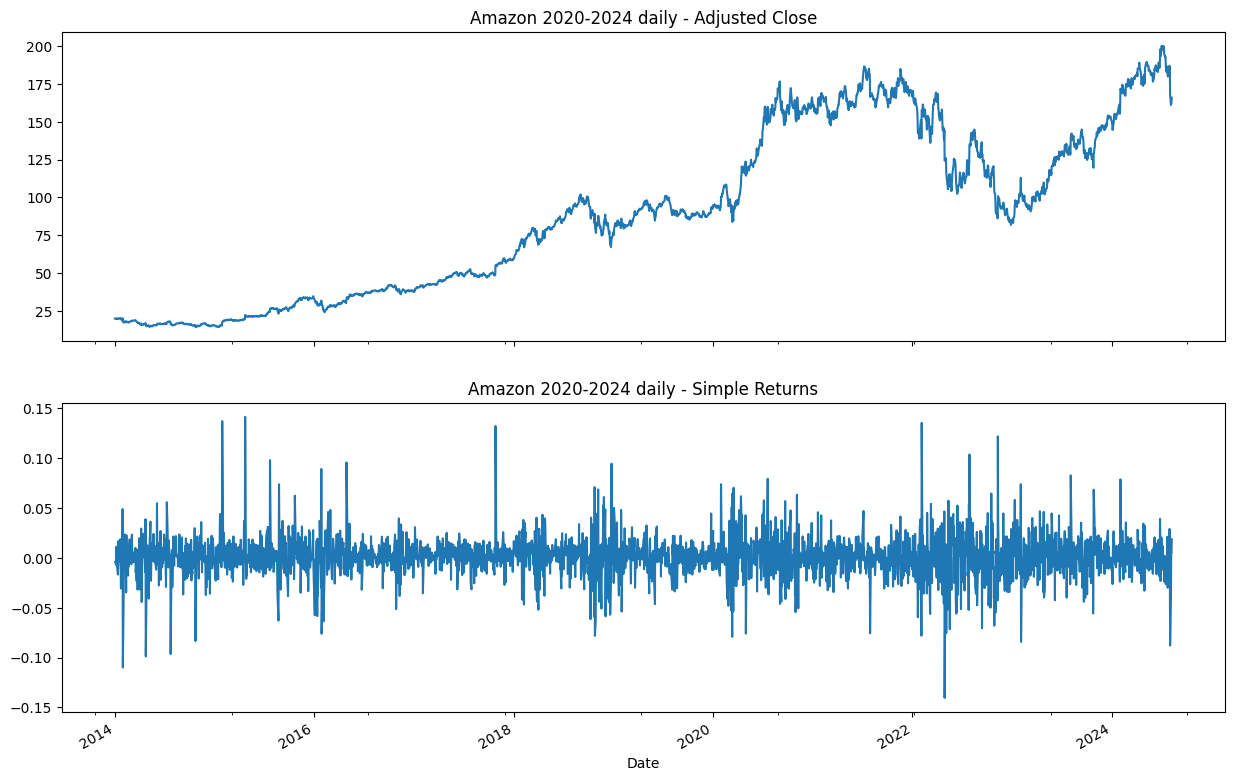

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
df["Adj Close"].plot(ax=ax[0], kind = "line", title = "Amazon 2020-2024 daily - Adjusted Close");
df["simple_rtn"].plot(ax=ax[1], kind = "line", title = "Amazon 2020-2024 daily - Simple Returns");

In [14]:
import cufflinks as cf
import plotly.offline as iplot

In [15]:
cf.go_offline()

In [16]:
qf = cf.QuantFig(raw_df, title="Amazon 2020-2024 daily", legend="top", name="Amazon price", kind='candlestick')
qf.add_volume()
qf.add_sma(periods=20, column="Close", color="red")
qf.add_ema(periods=20, color="green")

In [17]:
qf.iplot()

In [18]:
# 21 day rolling mean and std dev

In [19]:
df_rolling = df[["simple_rtn"]].rolling(window=21)\
                                .agg(["mean", "std"])
df_rolling.columns = df_rolling.columns.droplevel()

In [20]:
df_rolling.head(30)

,mean,std
Date,,
2014-01-02,NaN,NaN
2014-01-03,NaN,NaN
2014-01-06,NaN,NaN
2014-01-07,NaN,NaN
2014-01-08,NaN,NaN
2014-01-09,NaN,NaN
2014-01-10,NaN,NaN
2014-01-13,NaN,NaN
2014-01-14,NaN,NaN


In [21]:
df = df.join(df_rolling)

In [22]:
df

,Adj Close,simple_rtn,log_rtn,mean,std
Date,,,,,
2014-01-02,19.898500,NaN,NaN,NaN,NaN
2014-01-03,19.822001,-0.003845,-0.003852,NaN,NaN
2014-01-06,19.681499,-0.007088,-0.007113,NaN,NaN
2014-01-07,19.901501,0.011178,0.011116,NaN,NaN
2014-01-08,20.096001,0.009773,0.009726,NaN,NaN
...,...,...,...,...,...
2024-08-02,167.899994,-0.087847,-0.091948,-0.007444,0.023814
2024-08-05,161.020004,-0.040977,-0.041840,-0.009976,0.024440
2024-08-06,161.929993,0.005651,0.005635,-0.009538,0.024642


In [23]:
# upper and lower tresholds

In [24]:
n_sigmas = 3
df["upper"] = df["mean"] + n_sigmas * df["std"]
df["lower"] = df["mean"] - n_sigmas * df["std"]

In [25]:
# outlier identification

In [26]:
df["outlier"] = (
    (df["simple_rtn"] > df["upper"]) | (df["simple_rtn"] < df["lower"])

)

In [27]:
df["outlier"].unique()

array([False,  True])

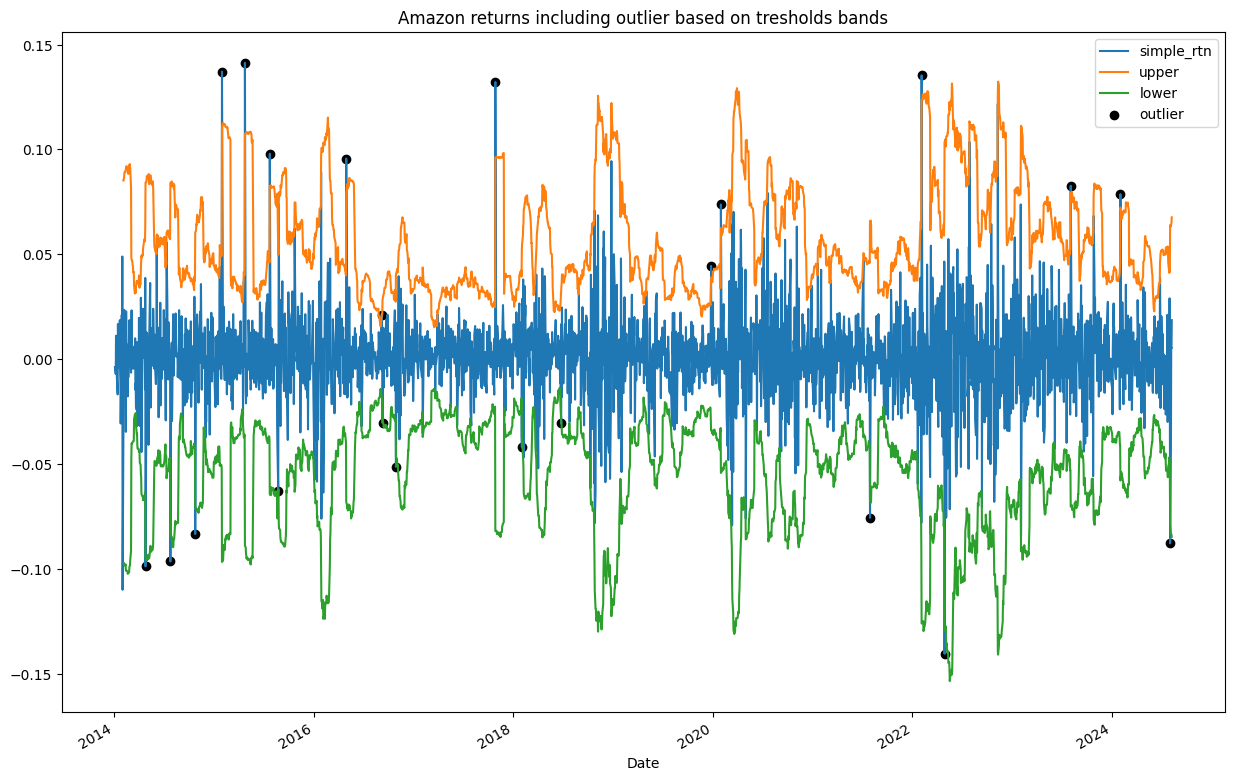

In [28]:
fig, ax = plt.subplots(figsize=(15, 10))

df[["simple_rtn", "upper", "lower"]].plot(ax=ax)
ax.scatter(df.loc[df["outlier"]].index,
           df.loc[df["outlier"], "simple_rtn"],
           color="black", label="outlier")
ax.set_title("Amazon returns including outlier based on tresholds bands")
ax.legend();
           

In [29]:
df[df["outlier"]==True]

,Adj Close,simple_rtn,log_rtn,mean,std,upper,lower,outlier
Date,,,,,,,,
2014-04-25,15.191500,-0.098828,-0.104060,-0.005375,0.029853,0.084185,-0.094935,True
2014-07-25,16.200500,-0.096484,-0.101461,-0.000113,0.028098,0.084180,-0.084406,True
2014-10-24,14.353000,-0.083403,-0.087087,-0.005207,0.021902,0.060500,-0.070915,True
2015-01-30,17.726500,0.137116,0.128495,0.006899,0.034542,0.110523,-0.096726,True
2015-04-24,22.254999,0.141311,0.132178,0.009188,0.032736,0.107397,-0.089021,True
2015-07-24,26.471001,0.097972,0.093465,0.009032,0.024536,0.082641,-0.064578,True
2015-08-24,23.168501,-0.062896,-0.064961,-0.006155,0.018639,0.049763,-0.062073,True
2016-04-29,32.979500,0.095664,0.091361,0.005303,0.024471,0.078717,-0.068112,True
2016-09-06,39.443501,0.021270,0.021047,0.001424,0.006589,0.021192,-0.018344,True


In [30]:
# Stationary test using Dickey-Fuller test
adfuller(df["Adj Close"])

(-0.7525069438541951,
 0.8326764488604026,
 27,
 2640,
 {'1%': -3.4328294203524243,
  '5%': -2.8626354202775866,
  '10%': -2.5673531303087693},
 11616.035698149379)

<Axes: xlabel='Date'>

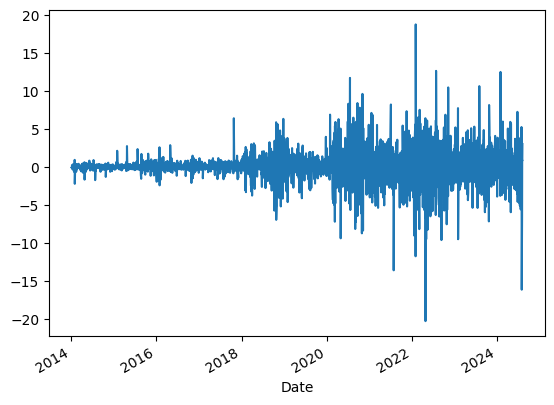

In [31]:
df["Adj Close"].diff(1).plot()

In [32]:
stat_test = df["Adj Close"].diff(1).dropna()

In [33]:
# Differencing stationary test

<Axes: xlabel='Date'>

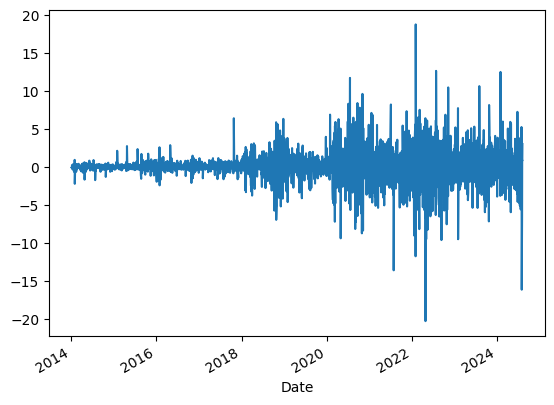

In [34]:
stat_test.plot()

In [35]:
adfuller(stat_test)

(-10.572628226392547,
 7.23922178151455e-19,
 26,
 2640,
 {'1%': -3.4328294203524243,
  '5%': -2.8626354202775866,
  '10%': -2.5673531303087693},
 11611.219496025256)

In [36]:
##### 

In [37]:
# ***
acf(df["Adj Close"])

array([1.        , 0.9985264 , 0.99709782, 0.99570913, 0.99437813,
       0.99291625, 0.99132081, 0.98970154, 0.98812641, 0.98661645,
       0.98508115, 0.98359957, 0.9821121 , 0.98057994, 0.979021  ,
       0.97747885, 0.97597294, 0.97441572, 0.9728002 , 0.9711262 ,
       0.96946095, 0.96780602, 0.96611492, 0.96446995, 0.96280004,
       0.96115306, 0.95961915, 0.95813447, 0.95656778, 0.95502885,
       0.95341988, 0.95191212, 0.9503907 , 0.9488873 , 0.94730388])

In [38]:
acf(stat_test)

array([ 1.        , -0.01096264, -0.02130756, -0.03003265,  0.04090636,
       -0.01483228, -0.00427146,  0.00158402, -0.04868692,  0.01892038,
       -0.01837876, -0.0018628 , -0.0043283 ,  0.03864215, -0.01601619,
       -0.03053597,  0.00582902,  0.00730865,  0.03485108, -0.011714  ,
       -0.02286643, -0.01019474, -0.02646657,  0.01471167, -0.01718707,
       -0.05526236, -0.04620552,  0.06770421,  0.00219996,  0.01752784,
       -0.03853267,  0.05062192, -0.0091113 ,  0.02886068, -0.02973713])

In [39]:
from pandas.plotting import lag_plot

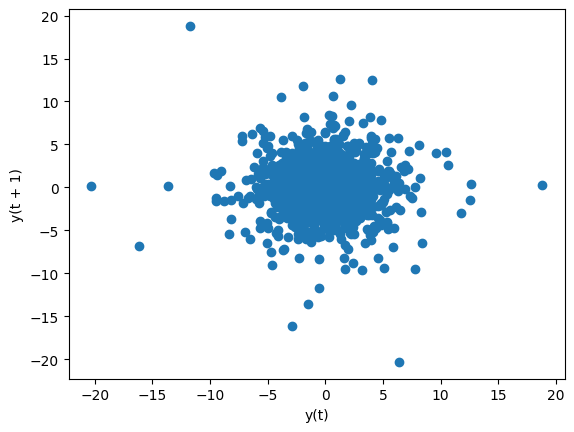

In [40]:
lag_plot(stat_test);

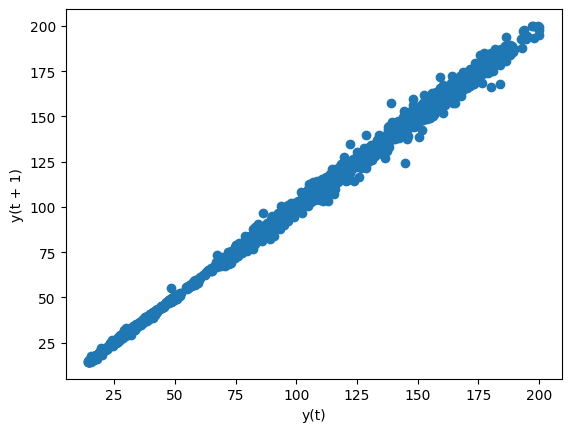

In [41]:
lag_plot(df["Adj Close"]);

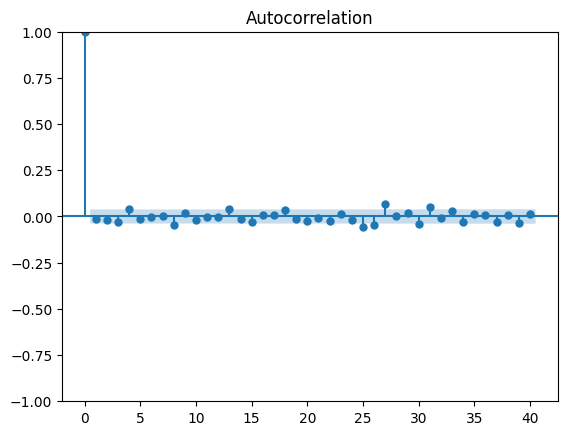

In [42]:
# Seasonality detection using autocorrelation - no seasonality found
plot_acf(stat_test, lags=40);

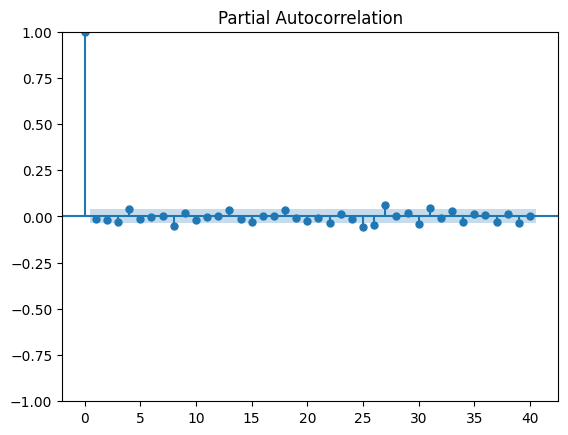

In [43]:
# Partial auto correlation function identifies AR to estimate number of lags.
plot_pacf(stat_test, method='ywm', lags=40);

In [44]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [45]:
df.index = pd.to_datetime(df.index)

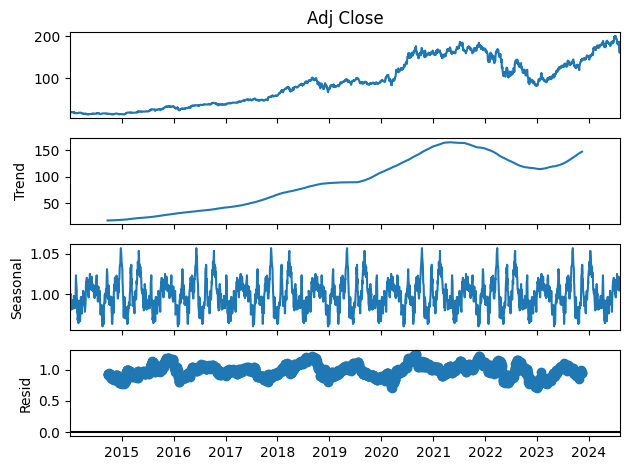

In [46]:
seasonal = seasonal_decompose(df["Adj Close"], period=365, model="multiplicative ").plot();

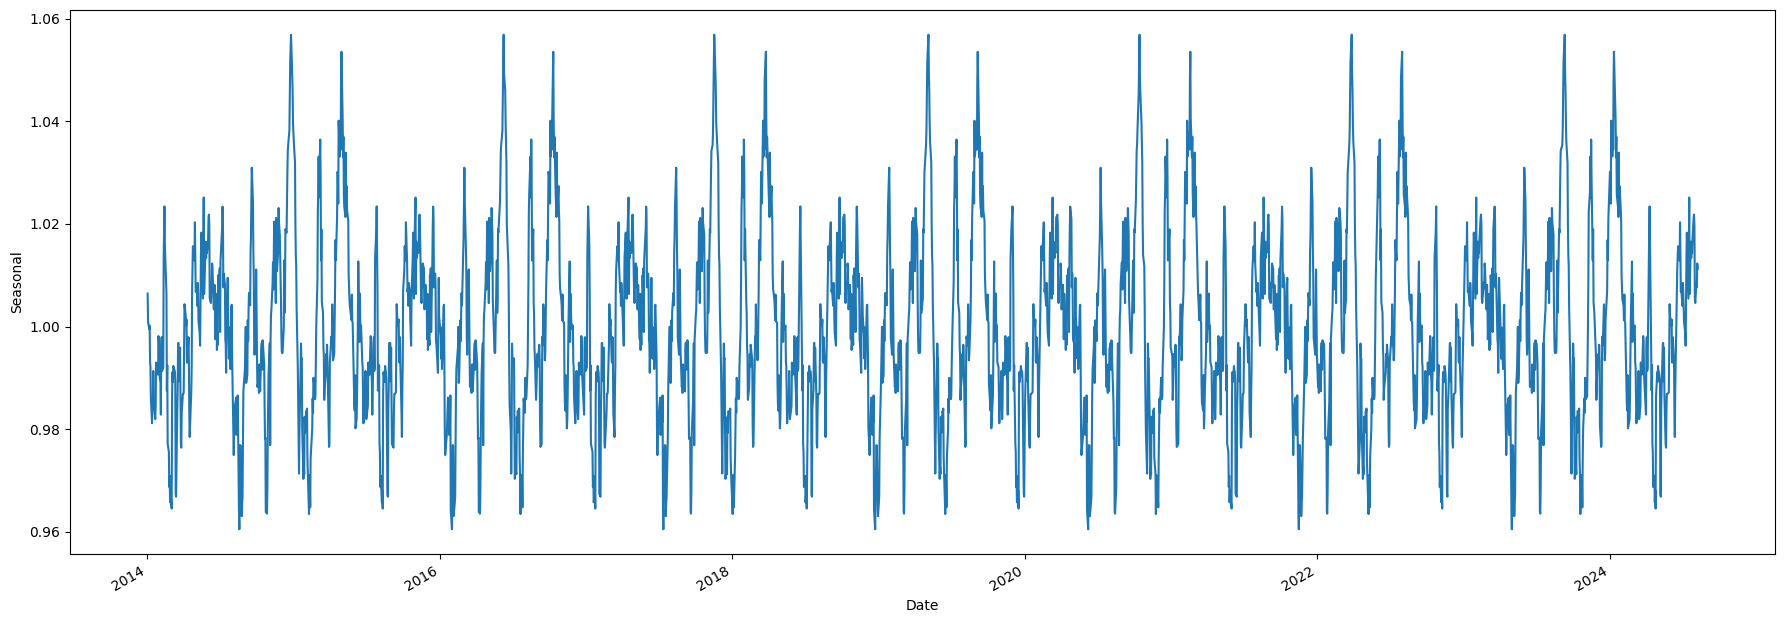

In [47]:
plt.figure(figsize=(22,8));
seasonal_decompose(df["Adj Close"], period=365, model="multiplicative ").seasonal.plot().set_ylabel("Seasonal");

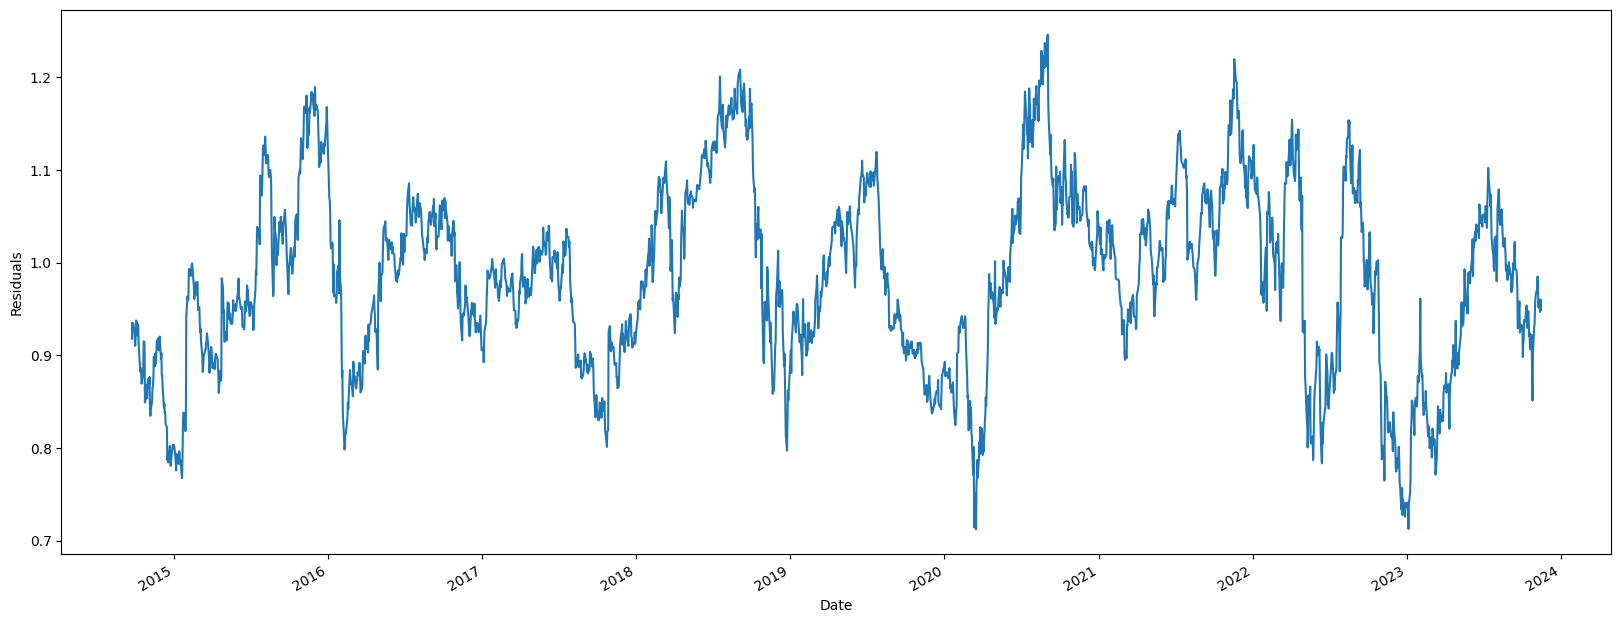

In [48]:
plt.figure(figsize=(20,8))
seasonal_decompose(df["Adj Close"], period=365, model="multiplicative ").resid.plot().set_ylabel("Residuals");

In [49]:
# Tripple exponential smooting - Holt-Winters method supporting  both -  trends and seasonality in the data.
# Exponential Smoothing is a widely used technique for forecasting time series data.

In [50]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [51]:
# multiplicative Tripple exponential smooting
df["TESmul12"] = ExponentialSmoothing(df["Adj Close"],trend='mul',seasonal='mul',seasonal_periods=12).fit().fittedvalues
df.head()

,Adj Close,simple_rtn,log_rtn,mean,std,upper,lower,outlier,TESmul12
Date,,,,,,,,,
2014-01-02,19.898500,NaN,NaN,NaN,NaN,NaN,NaN,False,19.902073
2014-01-03,19.822001,-0.003845,-0.003852,NaN,NaN,NaN,NaN,False,19.900879
2014-01-06,19.681499,-0.007088,-0.007113,NaN,NaN,NaN,NaN,False,19.796557
2014-01-07,19.901501,0.011178,0.011116,NaN,NaN,NaN,NaN,False,19.728180
2014-01-08,20.096001,0.009773,0.009726,NaN,NaN,NaN,NaN,False,19.861257


In [52]:
df.tail()

,Adj Close,simple_rtn,log_rtn,mean,std,upper,lower,outlier,TESmul12
Date,,,,,,,,,
2024-08-02,167.899994,-0.087847,-0.091948,-0.007444,0.023814,0.063997,-0.078885,True,183.261737
2024-08-05,161.020004,-0.040977,-0.041840,-0.009976,0.024440,0.063343,-0.083294,False,168.057977
2024-08-06,161.929993,0.005651,0.005635,-0.009538,0.024642,0.064389,-0.083464,False,161.039250
2024-08-07,162.770004,0.005187,0.005174,-0.009303,0.024763,0.064988,-0.083593,False,161.722137
2024-08-08,165.800003,0.018615,0.018444,-0.008524,0.025394,0.067660,-0.084707,False,163.156065


In [53]:
# exponential weighted moving average

In [54]:
span = 12
alpha = 2/(span+1)

df["EWMA12"] = df["Adj Close"].ewm(alpha=alpha,adjust=False).mean()

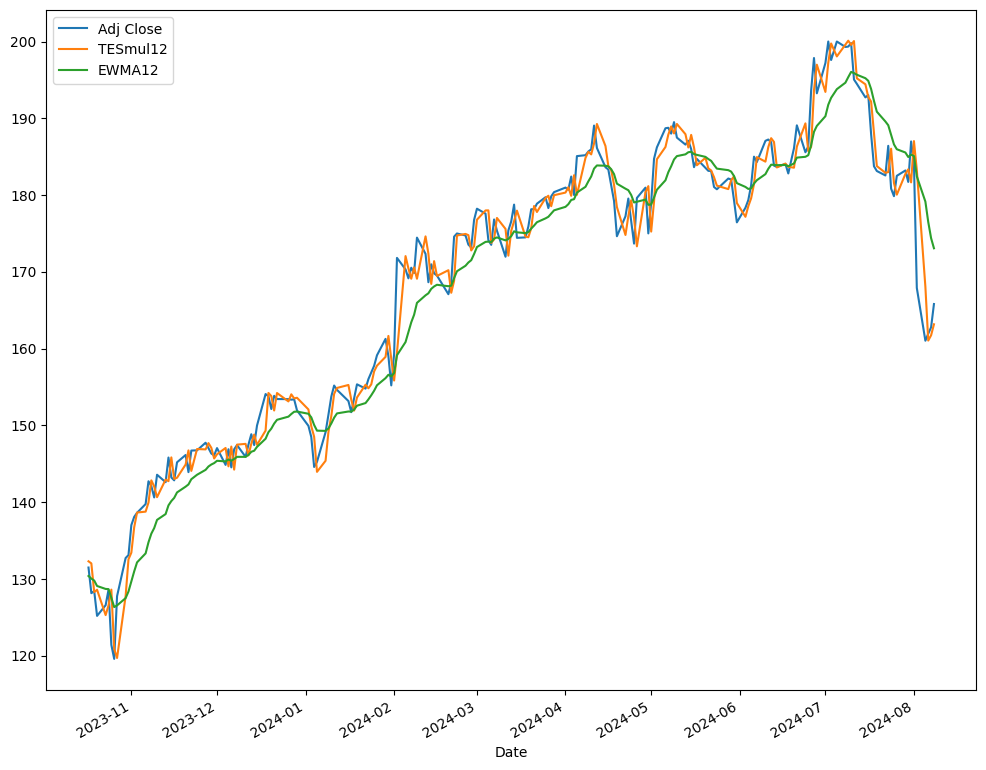

In [55]:
df[["Adj Close","TESmul12","EWMA12" ]].tail(204).plot(figsize=(12,10));

In [56]:
# train-test 80/20 split

In [57]:
split = int(df.shape[0]*.2)

In [58]:
df_train = df[:-split]
df_test = df[-split:]

In [59]:
df_test.shape

(533, 10)

In [60]:
start = len(df_train)
end = start + len(df_test) - 1

In [61]:
test_model_ExpSm = ExponentialSmoothing(df_train["Adj Close"],trend='add',seasonal='mul',seasonal_periods=365).fit()

In [62]:
predictions = test_model_ExpSm.forecast(533)

In [63]:
# model is pretty bad, negative value suggest that the Exponential Smoothing model with multiplicative trend and seasonal components might not be suitable that data.
# the predictions are  significantly worse than a simple mean

# interesting to see that additive trend and multiplicative seasonal comp. has smaller error than mul/ul or add/add or mul/add with seasonal period 365

r2_score(predictions, df_test["Adj Close"])

-7.193307856979917

In [64]:
# mean square error suggests that between predictions and actual values, the difference is around 26.61
mean_squared_error(predictions, df_test["Adj Close"])**0.5

26.841043796440335

In [65]:
# full data model fit, just to obtail 12 days graphical forecast overview (just to see with real data in the future ONLY!!) 

In [66]:
model_ExpSm = ExponentialSmoothing(df["Adj Close"],trend='add',seasonal='mul',seasonal_periods=365).fit()

In [67]:
pred_ES = model_ExpSm.forecast(12)

In [68]:
pred_ES

2668    165.331302
2669    166.092070
2670    167.381442
2671    167.321118
2672    164.791266
2673    165.867585
2674    167.048116
2675    168.696290
2676    168.798302
2677    169.982216
2678    168.805271
2679    169.653524
dtype: float64

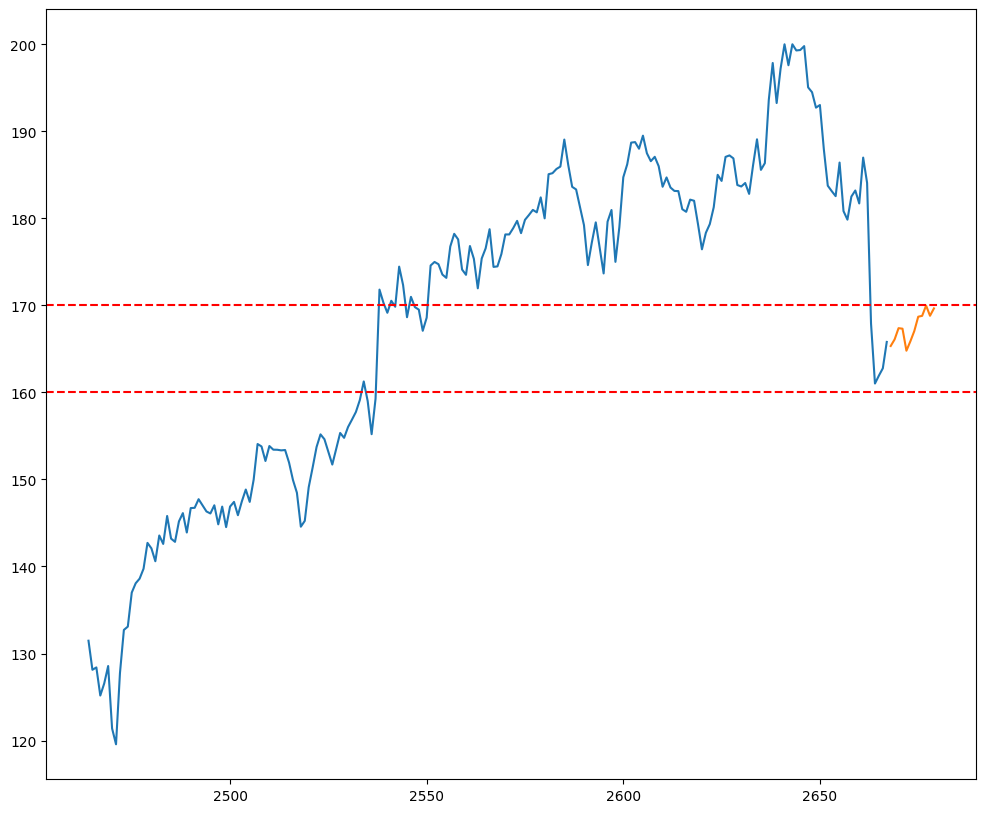

In [69]:
# Exponental Smoothing prediction 12 months (last 204 periods). 
# Interesting is that the prediction despite negative r2 looks reasonable (based on technical analysis only)

df["Adj Close"].reset_index(drop=True).tail(204).plot(figsize=(12,10));
pred_ES.plot(figsize=(12,10));
plt.axhline(y=170, color='red', linestyle='--', label='170 resistance');
plt.axhline(y=160, color='red', linestyle='--', label='y=160 support');

## Hidden Markov Model

In [70]:
df = raw_df.copy()

In [85]:
df["Log"] = np.log(df["Adj Close"])
df["Returns"] = df["Log"].pct_change()
df["Range"] = (df["High"] / df["Low"]) - 1
df['Bench_C_Rets'] = (1 + df['Adj Close'].pct_change()).cumprod()
df.dropna(inplace=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume,Log,Returns,Range,Bench_C_Rets
Date,,,,,,,,,,
2014-01-06,19.792500,19.8500,19.421000,19.681499,19.681499,63412000,2.979679,-0.002382,0.022090,0.992912
2014-01-07,19.752001,19.9235,19.714500,19.901501,19.901501,38320000,2.990795,0.003731,0.010601,1.004011
2014-01-08,19.923500,20.1500,19.802000,20.096001,20.096001,46330000,3.000521,0.003252,0.017574,1.013823
2014-01-09,20.185499,20.3445,19.922001,20.050501,20.050501,42060000,2.998254,-0.000755,0.021208,1.011528
2014-01-10,20.126499,20.1880,19.690001,19.882999,19.882999,53590000,2.989865,-0.002798,0.025292,1.003077


In [72]:
# Structure Data
X_train = df[["Returns", "Range"]]
X_train.head()

,Returns,Range
Date,,
2014-01-03,-0.001288,0.016380
2014-01-06,-0.002382,0.022090
2014-01-07,0.003731,0.010601
2014-01-08,0.003252,0.017574
2014-01-09,-0.000755,0.021208


In [73]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, silhouette_score

In [74]:
# parameter grid search
param_grid = {
    'n_components': [2, 3, 4],
    'covariance_type': ['full'],
    'n_init': [10, 50, 100, 200],
    'random_state':[42]
}

In [75]:
gmm_model = mix.GaussianMixture()

In [76]:
grid_search = GridSearchCV(estimator=gmm_model, param_grid=param_grid, scoring=make_scorer, cv=5, n_jobs=-1)

In [77]:
grid_search.fit(X_train)

GridSearchCV(cv=5, estimator=GaussianMixture(), n_jobs=-1,
             param_grid={'covariance_type': ['full'], 'n_components': [2, 3, 4],
                         'n_init': [10, 50, 100, 200], 'random_state': [42]},
             scoring=<function make_scorer at 0x0000023F52DEB7E0>)

In [78]:
# the best parameters and score
best_params = grid_search.best_params_
best_gmm = grid_search.best_estimator_
print("Best Parameters:", best_params)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'covariance_type': 'full', 'n_components': 2, 'n_init': 10, 'random_state': 42}
Best Score: nan


In [79]:
gmm_model = mix.GaussianMixture(n_components=2, covariance_type="full", n_init=10, random_state=42).fit(X_train)
print("Model Score:", gmm_model.score(X_train))

Model Score: 7.169232826931979


In [80]:
hidden_states = gmm_model.predict(X_train)
hidden_states

array([1, 1, 1, ..., 0, 0, 1], dtype=int64)

In [82]:
# Structure prices for chart plotting
i = 0
labels_0 = []
labels_1 = []

prices = df["Close"].values.astype(float)
print("Correct Number of rows: ", len(prices) == len(hidden_states))
for s in hidden_states:
    if s == 0:
        labels_0.append(prices[i])
        labels_1.append(float('nan'))
    if s == 1:
        labels_0.append(float('nan'))
        labels_1.append(prices[i])
        

    i += 1

Correct Number of rows:  True


In [ ]:
# The Markov model can confirm in what trend the stock currently is

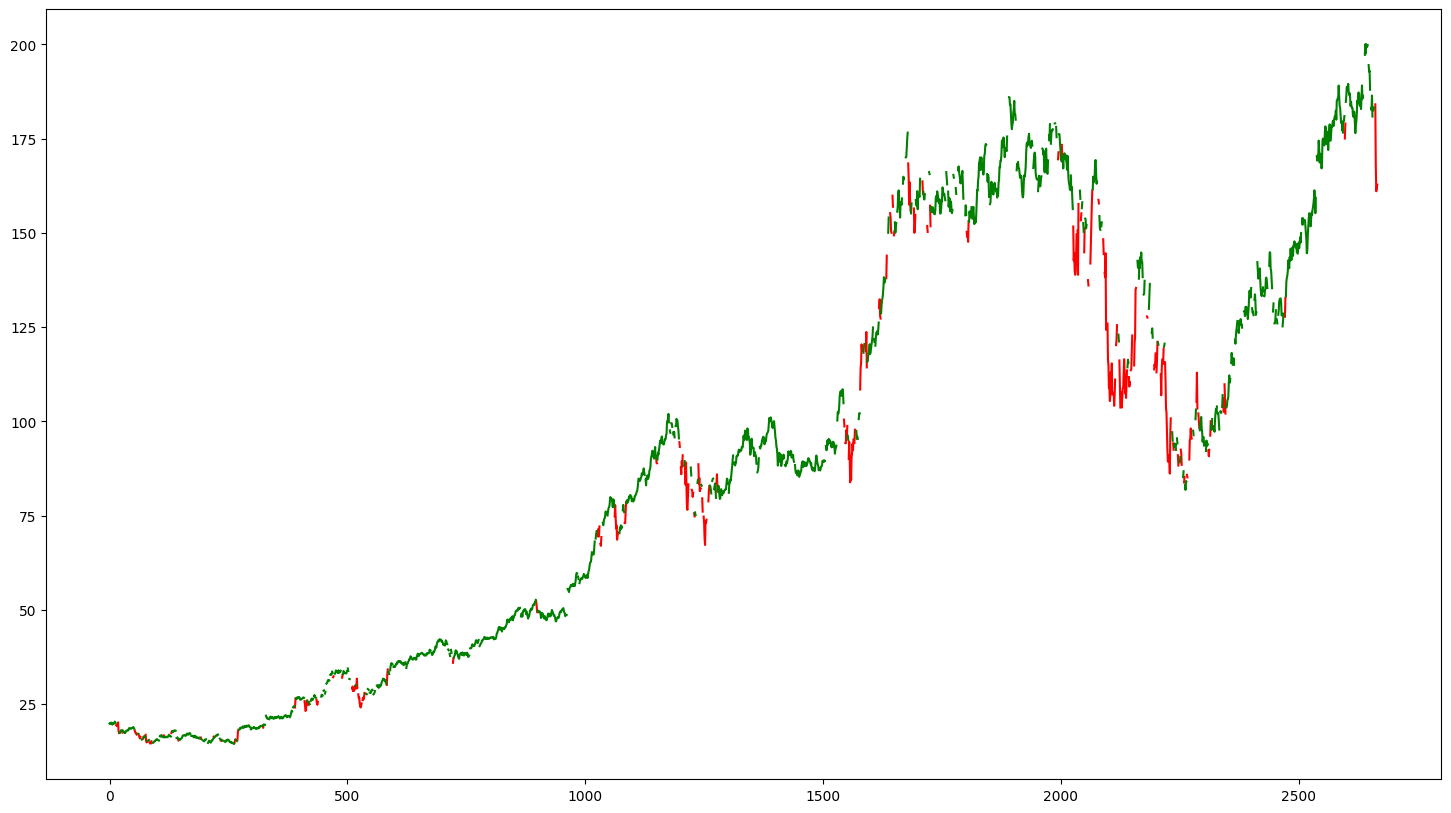

2667


In [83]:
# Plot chart
fig = plt.figure(figsize = (18,10))
plt.plot(labels_0, color="red")
plt.plot(labels_1, color="green")
#plt.plot(labels_2, color="orange")
#plt.plot(labels_3, color="black")
plt.show()
print(len(labels_0))

In [84]:
df

,Open,High,Low,Close,Adj Close,Volume,Log,Returns,Range
Date,,,,,,,,,
2014-01-03,19.914499,20.135500,19.811001,19.822001,19.822001,44204000,2.986792,-0.001288,0.016380
2014-01-06,19.792500,19.850000,19.421000,19.681499,19.681499,63412000,2.979679,-0.002382,0.022090
2014-01-07,19.752001,19.923500,19.714500,19.901501,19.901501,38320000,2.990795,0.003731,0.010601
2014-01-08,19.923500,20.150000,19.802000,20.096001,20.096001,46330000,3.000521,0.003252,0.017574
2014-01-09,20.185499,20.344500,19.922001,20.050501,20.050501,42060000,2.998254,-0.000755,0.021208
...,...,...,...,...,...,...,...,...,...
2024-08-02,166.750000,168.770004,160.550003,167.899994,167.899994,141448400,5.123369,-0.017630,0.051199
2024-08-05,154.210007,162.960007,151.610001,161.020004,161.020004,83149400,5.081529,-0.008166,0.074863
2024-08-06,161.710007,165.080002,158.539993,161.929993,161.929993,59950800,5.087164,0.001109,0.041251


## XGboost classification

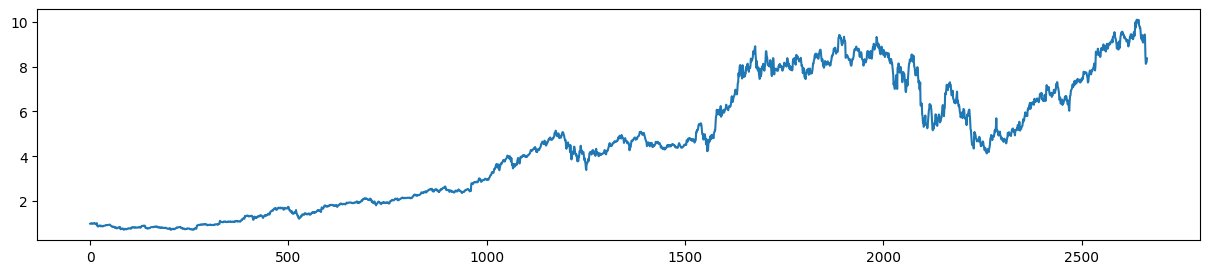

In [86]:
# Benchmark Returns Profile
fig = plt.figure(figsize = (15, 3))
plt.plot(df["Bench_C_Rets"].values)
plt.show()

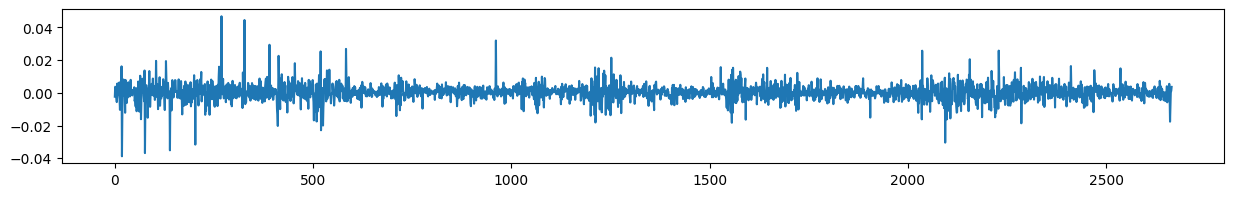

In [87]:
# Benchmark Returns Profile
fig = plt.figure(figsize = (15, 2))
plt.plot(df["Returns"].values)
plt.show()

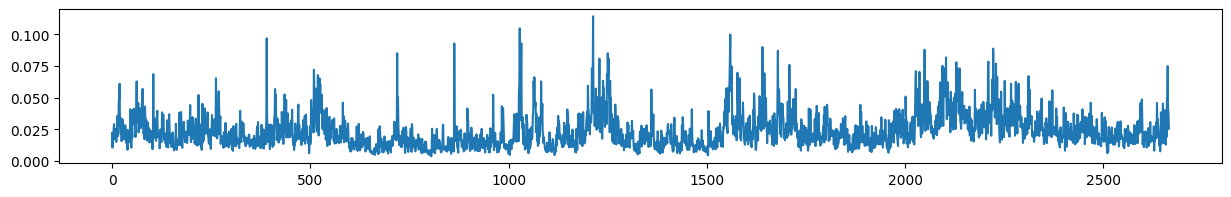

In [88]:
# Benchmark Range Profile
fig = plt.figure(figsize = (15, 2))
plt.plot(df["Range"].values)
plt.show()

### XGB Feature Engineering - Feature Expansion

##### Indicators

In [95]:
df

,Open,High,Low,Close,Adj Close,Volume,Log,Returns,Range,Bench_C_Rets,RSI,RSI_Ret
Date,,,,,,,,,,,,
2014-01-06,19.792500,19.850000,19.421000,19.681499,19.681499,63412000,2.979679,-0.002382,0.022090,0.992912,NaN,NaN
2014-01-07,19.752001,19.923500,19.714500,19.901501,19.901501,38320000,2.990795,0.003731,0.010601,1.004011,NaN,NaN
2014-01-08,19.923500,20.150000,19.802000,20.096001,20.096001,46330000,3.000521,0.003252,0.017574,1.013823,NaN,NaN
2014-01-09,20.185499,20.344500,19.922001,20.050501,20.050501,42060000,2.998254,-0.000755,0.021208,1.011528,NaN,NaN
2014-01-10,20.126499,20.188000,19.690001,19.882999,19.882999,53590000,2.989865,-0.002798,0.025292,1.003077,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-02,166.750000,168.770004,160.550003,167.899994,167.899994,141448400,5.123369,-0.017630,0.051199,8.470386,30.253894,0.666125
2024-08-05,154.210007,162.960007,151.610001,161.020004,161.020004,83149400,5.081529,-0.008166,0.074863,8.123297,26.239650,0.867315
2024-08-06,161.710007,165.080002,158.539993,161.929993,161.929993,59950800,5.087164,0.001109,0.041251,8.169205,27.607841,1.052142


In [94]:
# Add RSI
rsi = RSIIndicator(close=df["Close"], window=14).rsi()

df["RSI"] = rsi
df["RSI_Ret"] = df["RSI"] / df["RSI"].shift(1)

In [96]:
# Add Moving Average 12 and 21 days

df["MA_12"] = df["Close"].rolling(window=12).mean()
df["MA_21"] = df["Close"].rolling(window=21).mean()

In [97]:
# Day of Week

df["DOW"] = df.index.dayofweek

In [98]:
# Rolling Cumulative Returns
df["Roll_Rets"] = df["Returns"].rolling(window=30).sum()

In [99]:
# Rolling Cumulative Range
df["Avg_Range"] = df["Range"].rolling(window=30).mean()

##### Time Intervals

In [100]:
t_steps = [1, 2]
t_features = ["Returns", "Range", "RSI_Ret"]

for ts in t_steps:
    for tf in t_features:
        df[f"{tf}_T{ts}"] = df[tf].shift(ts)

In [101]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,Log,Returns,Range,Bench_C_Rets,...,MA_21,DOW,Roll_Rets,Avg_Range,Returns_T1,Range_T1,RSI_Ret_T1,Returns_T2,Range_T2,RSI_Ret_T2
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-06,19.792500,19.8500,19.421000,19.681499,19.681499,63412000,2.979679,-0.002382,0.022090,0.992912,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-07,19.752001,19.9235,19.714500,19.901501,19.901501,38320000,2.990795,0.003731,0.010601,1.004011,...,NaN,1,NaN,NaN,-0.002382,0.022090,NaN,NaN,NaN,NaN
2014-01-08,19.923500,20.1500,19.802000,20.096001,20.096001,46330000,3.000521,0.003252,0.017574,1.013823,...,NaN,2,NaN,NaN,0.003731,0.010601,NaN,-0.002382,0.022090,NaN
2014-01-09,20.185499,20.3445,19.922001,20.050501,20.050501,42060000,2.998254,-0.000755,0.021208,1.011528,...,NaN,3,NaN,NaN,0.003252,0.017574,NaN,0.003731,0.010601,NaN
2014-01-10,20.126499,20.1880,19.690001,19.882999,19.882999,53590000,2.989865,-0.002798,0.025292,1.003077,...,NaN,4,NaN,NaN,-0.000755,0.021208,NaN,0.003252,0.017574,NaN


In [102]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume,Log,Returns,Range,Bench_C_Rets,...,MA_21,DOW,Roll_Rets,Avg_Range,Returns_T1,Range_T1,RSI_Ret_T1,Returns_T2,Range_T2,RSI_Ret_T2
Date,,,,,,,,,,,,,,,,,,,,,
2024-08-02,166.750000,168.770004,160.550003,167.899994,167.899994,141448400,5.123369,-0.017630,0.051199,8.470386,...,187.833810,4,-0.019573,0.026474,-0.002999,0.048001,0.916242,0.005495,0.018866,1.226701
2024-08-05,154.210007,162.960007,151.610001,161.020004,161.020004,83149400,5.081529,-0.008166,0.074863,8.123297,...,185.977620,0,-0.030779,0.028356,-0.017630,0.051199,0.666125,-0.002999,0.048001,0.916242
2024-08-06,161.710007,165.080002,158.539993,161.929993,161.929993,59950800,5.087164,0.001109,0.041251,8.169205,...,184.198572,1,-0.026096,0.028711,-0.008166,0.074863,0.867315,-0.017630,0.051199,0.666125
2024-08-07,166.550003,167.580002,161.429993,162.770004,162.770004,48408200,5.092338,0.001017,0.038097,8.211583,...,182.457144,2,-0.025871,0.029366,0.001109,0.041251,1.052142,-0.008166,0.074863,0.867315
2024-08-08,165.169998,166.690002,162.550003,165.800003,165.800003,44616200,5.110782,0.003622,0.025469,8.364443,...,180.838573,3,-0.029571,0.028687,0.001017,0.038097,1.047477,0.001109,0.041251,1.052142


#### changing prices data to percentage change

In [104]:
df_fs = df.copy()

df_fs[["Open", "High", "Low", "Volume"]] = df_fs[["Open", "High", "Low", "Volume"]].pct_change()
df_fs

,Open,High,Low,Close,Adj Close,Volume,Log,Returns,Range,Bench_C_Rets,...,MA_21,DOW,Roll_Rets,Avg_Range,Returns_T1,Range_T1,RSI_Ret_T1,Returns_T2,Range_T2,RSI_Ret_T2
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-06,NaN,NaN,NaN,19.681499,19.681499,NaN,2.979679,-0.002382,0.022090,0.992912,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-07,-0.002046,0.003703,0.015113,19.901501,19.901501,-0.395698,2.990795,0.003731,0.010601,1.004011,...,NaN,1,NaN,NaN,-0.002382,0.022090,NaN,NaN,NaN,NaN
2014-01-08,0.008683,0.011368,0.004438,20.096001,20.096001,0.209029,3.000521,0.003252,0.017574,1.013823,...,NaN,2,NaN,NaN,0.003731,0.010601,NaN,-0.002382,0.022090,NaN
2014-01-09,0.013150,0.009653,0.006060,20.050501,20.050501,-0.092165,2.998254,-0.000755,0.021208,1.011528,...,NaN,3,NaN,NaN,0.003252,0.017574,NaN,0.003731,0.010601,NaN
2014-01-10,-0.002923,-0.007692,-0.011645,19.882999,19.882999,0.274132,2.989865,-0.002798,0.025292,1.003077,...,NaN,4,NaN,NaN,-0.000755,0.021208,NaN,0.003252,0.017574,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-02,-0.119077,-0.114533,-0.117227,167.899994,167.899994,1.008195,5.123369,-0.017630,0.051199,8.470386,...,187.833810,4,-0.019573,0.026474,-0.002999,0.048001,0.916242,0.005495,0.018866,1.226701
2024-08-05,-0.075202,-0.034426,-0.055684,161.020004,161.020004,-0.412157,5.081529,-0.008166,0.074863,8.123297,...,185.977620,0,-0.030779,0.028356,-0.017630,0.051199,0.666125,-0.002999,0.048001,0.916242
2024-08-06,0.048635,0.013009,0.045709,161.929993,161.929993,-0.278999,5.087164,0.001109,0.041251,8.169205,...,184.198572,1,-0.026096,0.028711,-0.008166,0.074863,0.867315,-0.017630,0.051199,0.666125


In [105]:
# Check for NaN
df_fs.dropna(inplace=True)
print(df_fs.isnull().values.any())

False


In [106]:
# Check for Inf values
dfobj = df_fs.isin([np.inf, -np.inf])
count = np.isinf(dfobj).values.sum()
count

0

In [107]:
# Check for non-numerical objects
df_fs.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2637 entries, 2014-02-18 to 2024-08-08
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          2637 non-null   float64
 1   High          2637 non-null   float64
 2   Low           2637 non-null   float64
 3   Close         2637 non-null   float64
 4   Adj Close     2637 non-null   float64
 5   Volume        2637 non-null   float64
 6   Log           2637 non-null   float64
 7   Returns       2637 non-null   float64
 8   Range         2637 non-null   float64
 9   Bench_C_Rets  2637 non-null   float64
 10  RSI           2637 non-null   float64
 11  RSI_Ret       2637 non-null   float64
 12  MA_12         2637 non-null   float64
 13  MA_21         2637 non-null   float64
 14  DOW           2637 non-null   int32  
 15  Roll_Rets     2637 non-null   float64
 16  Avg_Range     2637 non-null   float64
 17  Returns_T1    2637 non-null   float64
 18  Range_T1  

In [108]:
# statistical overview
df_fs.describe()

,Open,High,Low,Close,Adj Close,Volume,Log,Returns,Range,Bench_C_Rets,...,MA_21,DOW,Roll_Rets,Avg_Range,Returns_T1,Range_T1,RSI_Ret_T1,Returns_T2,Range_T2,RSI_Ret_T2
count,2637.000000,2637.000000,2637.000000,2637.000000,2637.000000,2637.000000,2637.000000,2637.000000,2637.000000,2637.000000,...,2637.000000,2637.000000,2637.000000,2637.000000,2637.000000,2637.000000,2637.000000,2637.000000,2637.000000,2637.000000
mean,0.001077,0.001018,0.001037,90.527484,90.527484,0.058703,4.257738,0.000230,0.023460,4.567021,...,89.931565,2.022753,0.006912,0.023436,0.000229,0.023456,1.004394,0.000231,0.023454,1.004435
std,0.021690,0.018705,0.019725,54.212546,54.212546,0.401874,0.775987,0.005082,0.013561,2.734968,...,53.997808,1.397841,0.026087,0.008387,0.005081,0.013562,0.096440,0.005084,0.013560,0.096482
min,-0.140537,-0.114533,-0.133108,14.347500,14.347500,-0.699481,2.663576,-0.036838,0.003750,0.723817,...,15.007500,0.000000,-0.095982,0.008897,-0.036838,0.003750,0.597055,-0.036838,0.003750,0.597055
25%,-0.009289,-0.007174,-0.008034,38.338501,38.338501,-0.182399,3.646455,-0.002093,0.014160,1.934139,...,38.230214,1.000000,-0.007061,0.017042,-0.002093,0.014160,0.950311,-0.002093,0.014160,0.950311
50%,0.001202,0.000740,0.001546,89.464996,89.464996,-0.023162,4.493847,0.000252,0.019977,4.513419,...,89.622523,2.000000,0.007531,0.021809,0.000244,0.019968,1.004481,0.000244,0.019968,1.004481
75%,0.011290,0.009202,0.010662,139.940002,139.940002,0.199278,4.941214,0.002662,0.029154,7.059832,...,136.841905,3.000000,0.022014,0.028014,0.002661,0.029154,1.049715,0.002662,0.029154,1.049721
max,0.177623,0.180836,0.138342,200.000000,200.000000,5.814252,5.298317,0.046784,0.114207,10.089799,...,193.100000,4.000000,0.106759,0.048384,0.046784,0.114207,1.738508,0.046784,0.114207,1.738508


## XGBoost

In [109]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import plot_tree
from sklearn.metrics import RocCurveDisplay, roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


In [110]:
df

,Open,High,Low,Close,Adj Close,Volume,Log,Returns,Range,Bench_C_Rets,...,MA_21,DOW,Roll_Rets,Avg_Range,Returns_T1,Range_T1,RSI_Ret_T1,Returns_T2,Range_T2,RSI_Ret_T2
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-06,19.792500,19.850000,19.421000,19.681499,19.681499,63412000,2.979679,-0.002382,0.022090,0.992912,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-07,19.752001,19.923500,19.714500,19.901501,19.901501,38320000,2.990795,0.003731,0.010601,1.004011,...,NaN,1,NaN,NaN,-0.002382,0.022090,NaN,NaN,NaN,NaN
2014-01-08,19.923500,20.150000,19.802000,20.096001,20.096001,46330000,3.000521,0.003252,0.017574,1.013823,...,NaN,2,NaN,NaN,0.003731,0.010601,NaN,-0.002382,0.022090,NaN
2014-01-09,20.185499,20.344500,19.922001,20.050501,20.050501,42060000,2.998254,-0.000755,0.021208,1.011528,...,NaN,3,NaN,NaN,0.003252,0.017574,NaN,0.003731,0.010601,NaN
2014-01-10,20.126499,20.188000,19.690001,19.882999,19.882999,53590000,2.989865,-0.002798,0.025292,1.003077,...,NaN,4,NaN,NaN,-0.000755,0.021208,NaN,0.003252,0.017574,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-02,166.750000,168.770004,160.550003,167.899994,167.899994,141448400,5.123369,-0.017630,0.051199,8.470386,...,187.833810,4,-0.019573,0.026474,-0.002999,0.048001,0.916242,0.005495,0.018866,1.226701
2024-08-05,154.210007,162.960007,151.610001,161.020004,161.020004,83149400,5.081529,-0.008166,0.074863,8.123297,...,185.977620,0,-0.030779,0.028356,-0.017630,0.051199,0.666125,-0.002999,0.048001,0.916242
2024-08-06,161.710007,165.080002,158.539993,161.929993,161.929993,59950800,5.087164,0.001109,0.041251,8.169205,...,184.198572,1,-0.026096,0.028711,-0.008166,0.074863,0.867315,-0.017630,0.051199,0.666125


In [111]:
# Specify Target
df.loc[df["Range"].shift(-1) > df["Avg_Range"], "TARGET"] = 1
df.loc[df["Range"].shift(-1) <= df["Avg_Range"], "TARGET"] = 0

In [112]:
# Fill NA
df["TARGET"].fillna(0, inplace=True)
df.tail()

,Open,High,Low,Close,Adj Close,Volume,Log,Returns,Range,Bench_C_Rets,...,DOW,Roll_Rets,Avg_Range,Returns_T1,Range_T1,RSI_Ret_T1,Returns_T2,Range_T2,RSI_Ret_T2,TARGET
Date,,,,,,,,,,,,,,,,,,,,,
2024-08-02,166.750000,168.770004,160.550003,167.899994,167.899994,141448400,5.123369,-0.017630,0.051199,8.470386,...,4,-0.019573,0.026474,-0.002999,0.048001,0.916242,0.005495,0.018866,1.226701,1.0
2024-08-05,154.210007,162.960007,151.610001,161.020004,161.020004,83149400,5.081529,-0.008166,0.074863,8.123297,...,0,-0.030779,0.028356,-0.017630,0.051199,0.666125,-0.002999,0.048001,0.916242,1.0
2024-08-06,161.710007,165.080002,158.539993,161.929993,161.929993,59950800,5.087164,0.001109,0.041251,8.169205,...,1,-0.026096,0.028711,-0.008166,0.074863,0.867315,-0.017630,0.051199,0.666125,1.0
2024-08-07,166.550003,167.580002,161.429993,162.770004,162.770004,48408200,5.092338,0.001017,0.038097,8.211583,...,2,-0.025871,0.029366,0.001109,0.041251,1.052142,-0.008166,0.074863,0.867315,0.0
2024-08-08,165.169998,166.690002,162.550003,165.800003,165.800003,44616200,5.110782,0.003622,0.025469,8.364443,...,3,-0.029571,0.028687,0.001017,0.038097,1.047477,0.001109,0.041251,1.052142,0.0


#### Train Test Split

In [113]:
# Feature Selection
df_tts = df.copy()
df_tts = df_tts[["Returns", "Range", "RSI", "RSI_Ret", "Returns_T1", "RSI_Ret_T1", "TARGET"]]

In [114]:
# Split into X and Y Data
X = df_tts.iloc[:, : -1]
y = df_tts.iloc[:, -1]

In [115]:
# Perform Train Test Split (Timeseries based method)
train_size_rate = 0.7
train_size = int(len(X) * train_size_rate)
test_size = len(X) - train_size

X_train = X.head(train_size)
y_train = y.head(train_size)
X_test = X.tail(test_size)
y_test = y.tail(test_size)

size_check = len(y_test) + len(y_train) == len(X)
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)
print("Size Matches: ", size_check)

Shape of X_train:  (1866, 6)
Shape of y_train:  (1866,)
Shape of X_test:  (800, 6)
Shape of y_test:  (800,)
Size Matches:  True


### Model

In [117]:
# Select type of model to optimize for
is_binary = True
is_optimise_for_precision = True

In [118]:
# Determine Objective and Eval Metrics
if is_binary:
    objective = "binary:logistic"
    eval_metric = "logloss"
    eval_metric_list = ["error", "logloss", eval_metric]
else:
    objective = "multi:softmax"
    eval_metric = "mlogloss"
    eval_metric_list = ["merror", "mlogloss", eval_metric]

In [119]:
# Refine Eval Metric
if is_binary and is_optimise_for_precision:
    eval_metric = "aucpr"
    scoring = "precision"
elif is_binary and not is_optimise_for_precision:
    eval_metric = "auc"
    scoring = "f1"
else:
    scoring = "accuracy"

In [120]:
# Hyperparams: ne: 80, lr: 0.01 md: 3 gm: 6
ne = 150
lr = 0.01
md = 2
gm = 6

In [121]:
# XGBOOST Classifier
classifier = XGBClassifier(
    objective=objective,
    booster="gbtree",
    eval_metric=eval_metric,
    n_estimators=ne,
    learning_rate=lr,
    max_depth=md,
    gamma=gm,
    subsample=0.8,
    colsample_bytree=1,
    random_state=1,
    use_label_encoder=False
)

In [122]:
# Fit Model
eval_set = [(X_train, y_train), (X_test, y_test)]
classifier.fit(X_train, y_train, eval_set=eval_set, verbose=False)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric='aucpr', feature_types=None, gamma=6,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, random_state=1, ...)

## Predictions

In [123]:
# Get Predictions Training
train_yhat = classifier.predict(X_train)
train_yhat_proba = classifier.predict_proba(X_train)
print("Preds Training Data: \n", train_yhat[:10])
print("Preds Probabilities Training Data: \n", train_yhat_proba[:3])

Preds Training Data: 
 [0 0 0 0 0 0 0 0 0 0]
Preds Probabilities Training Data: 
 [[0.6812223  0.31877765]
 [0.6894179  0.3105821 ]
 [0.69038975 0.30961025]]


In [138]:
# Get Predictions Test
test_yhat = classifier.predict(X_test)
test_yhat_proba = classifier.predict_proba(X_test)
print("Preds Test Data: \n", test_yhat[:10])
print("Preds Probabilities Training Data: \n", test_yhat_proba[:3])

Preds Test Data: 
 [0 0 0 0 0 0 0 0 0 0]
Preds Probabilities Training Data: 
 [[0.54646134 0.4535387 ]
 [0.6821991  0.31780088]
 [0.6681348  0.33186522]]


In [139]:
# Set K-Fold Cross Validation Levels
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)

In [140]:
# Training Results
train_results = cross_val_score(classifier, X_train, y_train, scoring=scoring, cv=cv, n_jobs=1)

In [141]:
# Retrieve performance metrics
results = classifier.evals_result()
epochs = len(results["validation_0"]["aucpr"])
x_axis = range(0, epochs)

In [142]:
results["validation_0"]["aucpr"]

[0.546685363902361,
 0.5762473395180117,
 0.5755653621365271,
 0.5822769946331163,
 0.5843644866564758,
 0.586280155611953,
 0.5857433297500635,
 0.5882187879767178,
 0.5918069403673953,
 0.5922086904154487,
 0.5944920346387055,
 0.5954076131522128,
 0.5947964350401829,
 0.5963821127493418,
 0.5984493155089383,
 0.6032752920803841,
 0.6020199773028629,
 0.6017472110969722,
 0.6021674842056299,
 0.6019087928195055,
 0.6031313564150202,
 0.6051306838573788,
 0.6050467886063631,
 0.6050595588657182,
 0.6057593281935303,
 0.6052852724801464,
 0.6049866885587605,
 0.6050191151159905,
 0.6057683062833448,
 0.605499062349798,
 0.6056157391851167,
 0.6065826869901462,
 0.6064980518163604,
 0.6073954060047186,
 0.6080164809504867,
 0.6074340723601598,
 0.6076736190234024,
 0.6085264091096606,
 0.6083856970990913,
 0.6083571493230711,
 0.6089873467003383,
 0.6108034724937401,
 0.6124625498166546,
 0.6136104927118554,
 0.6138241914354559,
 0.6137507648226113,
 0.614349212123743,
 0.61469624652163

In [143]:
results

{'validation_0': OrderedDict([('aucpr',
               [0.546685363902361,
                0.5762473395180117,
                0.5755653621365271,
                0.5822769946331163,
                0.5843644866564758,
                0.586280155611953,
                0.5857433297500635,
                0.5882187879767178,
                0.5918069403673953,
                0.5922086904154487,
                0.5944920346387055,
                0.5954076131522128,
                0.5947964350401829,
                0.5963821127493418,
                0.5984493155089383,
                0.6032752920803841,
                0.6020199773028629,
                0.6017472110969722,
                0.6021674842056299,
                0.6019087928195055,
                0.6031313564150202,
                0.6051306838573788,
                0.6050467886063631,
                0.6050595588657182,
                0.6057593281935303,
                0.6052852724801464,
                0.60498668

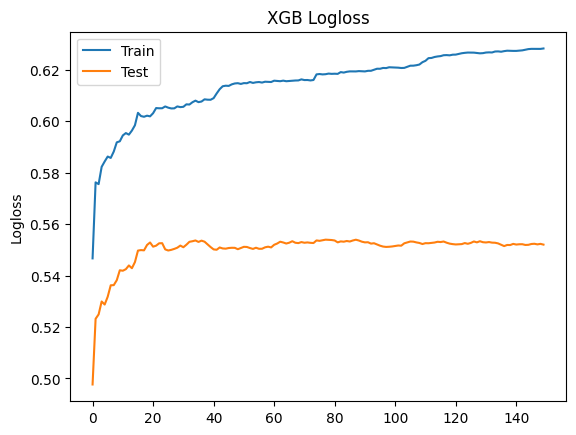

In [144]:
# Plot Log Loss
fig, ax = plt.subplots()
ax.plot(x_axis, results["validation_0"]["aucpr"], label="Train")
ax.plot(x_axis, results["validation_1"]["aucpr"], label="Test")
ax.legend()
plt.ylabel("Logloss")
plt.title("XGB Logloss")
plt.show()

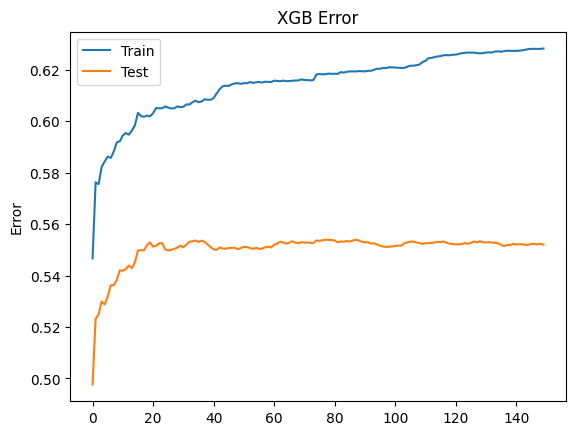

In [145]:
# Plot Classification Error
fig, ax = plt.subplots()
ax.plot(x_axis, results["validation_0"]["aucpr"], label="Train")
ax.plot(x_axis, results["validation_1"]["aucpr"], label="Test")
ax.legend()
plt.ylabel("Error")
plt.title("XGB Error")
plt.show()

### Evaluation Metrics - ROC Curve

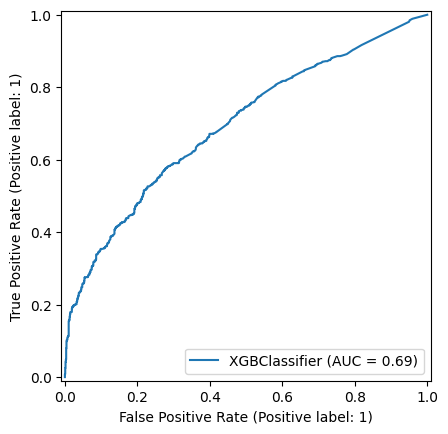

In [146]:
# Plot Training ROC Curve
RocCurveDisplay.from_estimator(classifier,X_train, y_train);

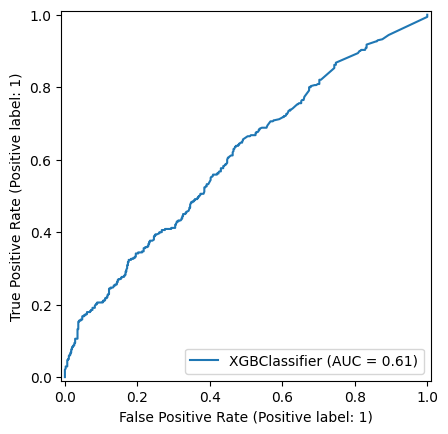

In [147]:
# Plot Test ROC Curve
RocCurveDisplay.from_estimator(classifier, X_test, y_test)

### Performance Evaluation Comparison

In [148]:
# Set K-Fold Cross Validation Levels
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)

In [149]:
# Training and Test Results
train_results = cross_val_score(classifier, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)
test_results = cross_val_score(classifier, X_test, y_test, scoring=scoring, cv=cv, n_jobs=-1)

In [150]:
# Comparison of Results
print("TRAIN:")
print("Average Acc K-Fold", round(train_results.mean(), 2))
print("Std Dev K-Fold", round(train_results.std(), 2))
print("Precision Score 0", round(precision_score(y_train, train_yhat, average=None)[0], 3))
print("Precision Score 1", round(precision_score(y_train, train_yhat, average=None)[1], 3))
print("----- ----- ----- ----- ----- ----- -----")
print("TEST:")
print("Average Acc K-Fold", round(test_results.mean(), 2))
print("Std Dev K-Fold", round(test_results.std(), 2))
print("Precision Score 0", round(precision_score(y_test, test_yhat, average=None)[0], 3))
print("Precision Score 1", round(precision_score(y_test, test_yhat, average=None)[1], 3))
print("")

TRAIN:
Average Acc K-Fold 0.68
Std Dev K-Fold 0.03
Precision Score 0 0.675
Precision Score 1 0.758
----- ----- ----- ----- ----- ----- -----
TEST:
Average Acc K-Fold 0.61
Std Dev K-Fold 0.1
Precision Score 0 0.609
Precision Score 1 0.573



In [151]:
# Show summary report - Training
print(classification_report(y_train, train_yhat))

              precision    recall  f1-score   support

         0.0       0.67      0.95      0.79      1148
         1.0       0.76      0.27      0.40       718

    accuracy                           0.69      1866
   macro avg       0.72      0.61      0.59      1866
weighted avg       0.71      0.69      0.64      1866



In [152]:
# Show summary report - Test
print(classification_report(y_test, test_yhat))

              precision    recall  f1-score   support

         0.0       0.61      0.86      0.71       460
         1.0       0.57      0.25      0.35       340

    accuracy                           0.60       800
   macro avg       0.59      0.56      0.53       800
weighted avg       0.59      0.60      0.56       800



### Performance Evaluation - Confusion Matrix

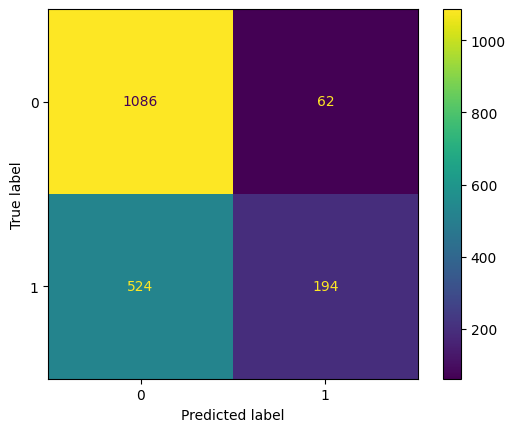

In [155]:
# Training Confusion Matrix
cm_train = confusion_matrix(y_train, train_yhat);
ConfusionMatrixDisplay(cm_train).plot();

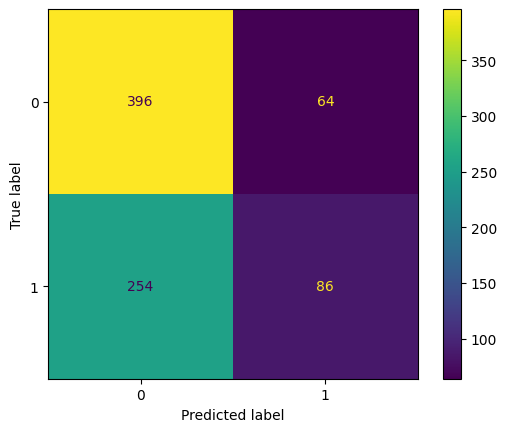

In [156]:
# Test Confusion Matrix
cm_test = confusion_matrix(y_test, test_yhat);
ConfusionMatrixDisplay(cm_test).plot();

### Feature Importance

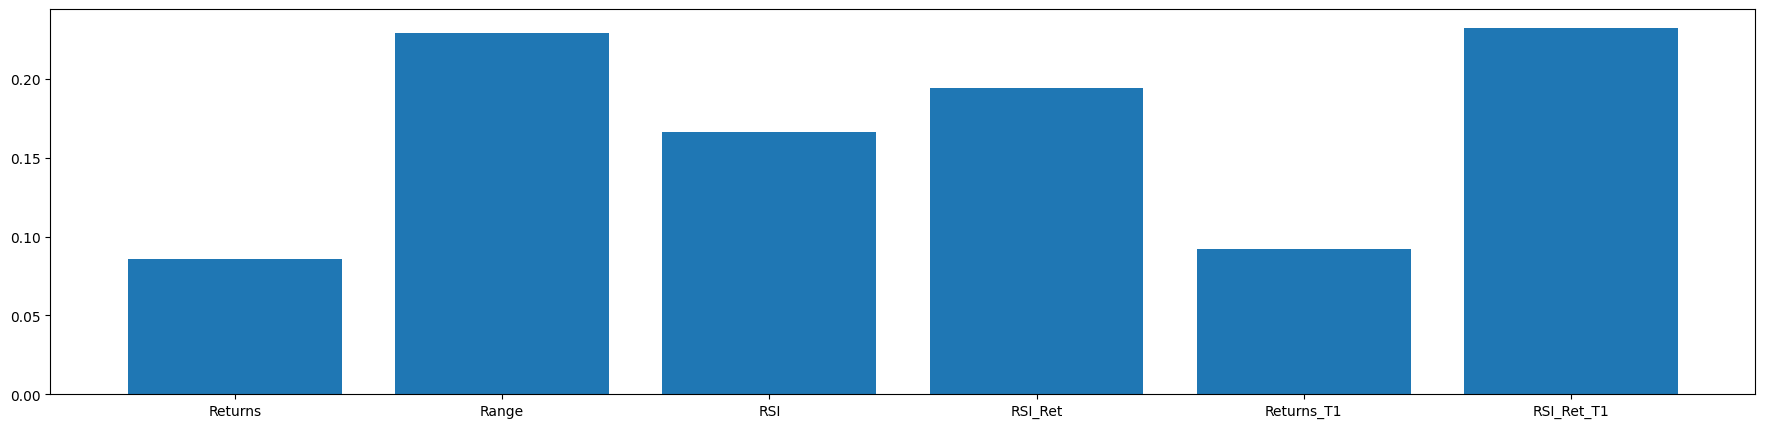

In [157]:
# Plot Feature Importances
fig = plt.figure(figsize=(22, 5))
importance_labels = X.columns
importance_features = classifier.feature_importances_
plt.bar(importance_labels, importance_features)
plt.show()

### XGBOOST TREE

<Axes: >

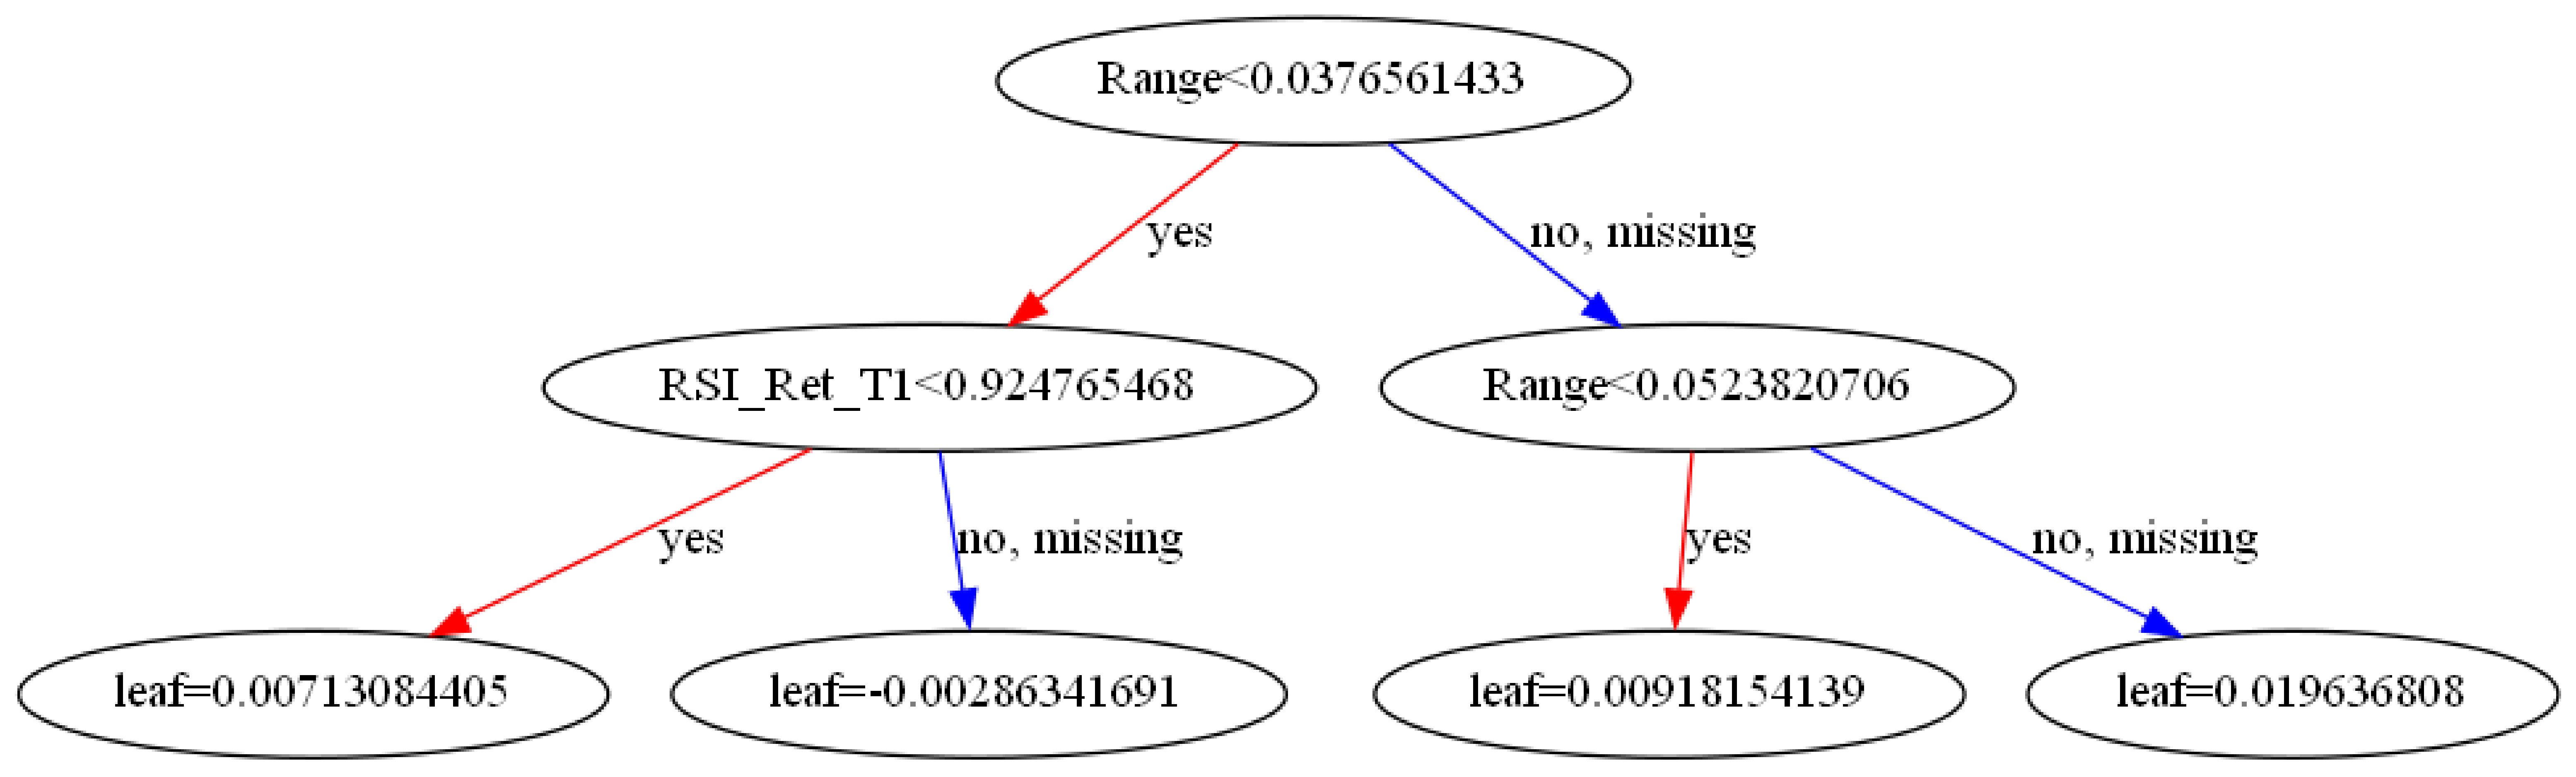

In [159]:
from matplotlib.pylab import rcParams

rcParams["figure.figsize"] = 80, 50
plot_tree(classifier)